# Dependencies

In [1]:
from typing import Tuple

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Constant values

- *Q_OUTLIERS* stands for the number of **anomalies** that we want to introduce to the dataset
- *Q_DATAPOINTS* refers to the **normal** datapoints to include in the dataset

In [2]:
Q_OUTLIERS = 50
Q_DATAPOINTS = 200

# Auxiliary functions

This function receives a numpy array containing prediction values for each data point, which could be either 1 or -1.

Its goal is to count the outliers in order to contrast this number against the total number of outliers to take some accuracy metrics later on

In [3]:
def count_anomalies(li: np.ndarray) -> int:
    return sum(map(lambda x : x == -1, li))

The function below receives two integer values, the first one being the number of normal data points meanwhile the second one represents the number of anomalies to generate following an uniform distribution.

In [4]:
def create_dataset(q_train: int, q_out: int) -> Tuple[np.ndarray, np.ndarray]:
    X = 0.3 * np.random.randn(q_train, 2)
    X_norm = np.r_[X + 2, X - 2]

    X_outliers = np.random.uniform(low=-4, high=4, size=(q_out, 2))

    return X_norm, X_outliers

This function maps anomalies to positions by correlating predictions to original set

In [5]:
def correlate_indexes(pred_arr: np.ndarray, original_arr: np.ndarray) -> np.ndarray:
    # Get outliers' index
    anom_index = np.where(pred_arr == -1)

    # Rerturn outliers' exact position from base set by correlating indexes
    return original_arr[anom_index]

Function for generating standardized metrics

In [6]:
def metrics_gen(orig_outliers: np.ndarray, predicted_outliers: np.ndarray, 
                correct_outliers: np.ndarray, false_outliers: np.ndarray, 
                undetected_outliers: np.ndarray):
    print('Accuracy on test set: {:.2f}%'.format(100 * len(correct_outliers) / len(X_test_outliers)))
    print('False detection ratio: {:.2f}%'.format(100 * len(false_outliers) / len(test_anom)))
    print('Undetection ratio: {:.2f}%'.format(100 * len(undetected_outliers) / len(X_test_outliers)))

We set a seed for random values generation. This way results would remain the same whenever we run

In [7]:
np.random.seed(2)

# Dataset Generation

In this section we will create two datasets, one which will be used to fit the model and the other one for testing purposes.

Both datasets will follow a *normal distribution* and some **outliers** (20% of total data points) will be added to both.

These outliers will be generated following an uniform distribution between higher-highs and lower-lows compared to the base sets.

In this case, values will be:

- Outliers: `(x, y) / {x ∈ [-4, 4], y ∈ [-4, 4]}`  

- Base clusters: 
    - `(x, y) / {x ∈ [1, 3], y ∈ [1, 3]}` 
    - `(x, y) / {x ∈ [-3, -1], y ∈ [-3, -1]}`

In the cells below, we will generate the datasets following distributions explained above (same distribution applies to both train and test sets).

**Training set**

In [8]:
X_train = create_dataset(Q_DATAPOINTS, Q_OUTLIERS)
X_train_normal = X_train[0]
X_train_outliers = X_train[1]

# Merge outliers into the normally distributed sub-set
X_train = np.append(X_train_normal, X_train_outliers, axis=0)

**Test set**

In [9]:
X_test = create_dataset(Q_DATAPOINTS, Q_OUTLIERS)
X_test_normal = X_test[0]
X_test_outliers = X_test[1]

# Merge outliers into the normally distributed sub-set
X_test = np.append(X_test_normal, X_test_outliers, axis=0)

# Dataset distribution

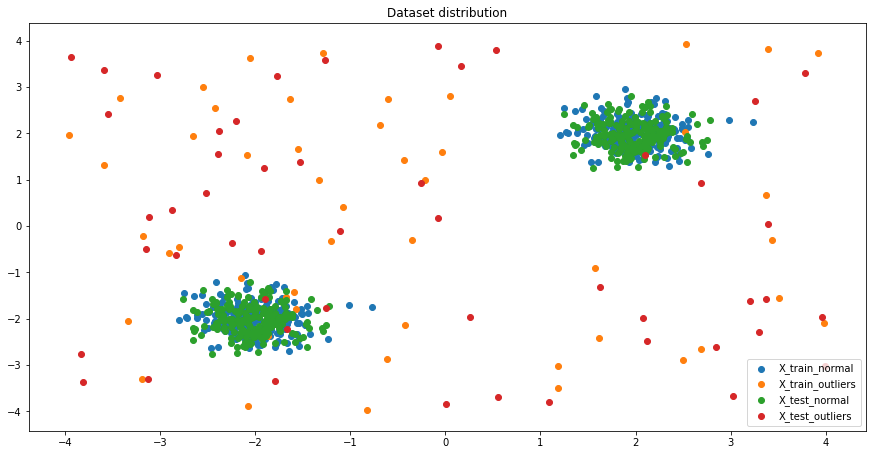

In [10]:
plt.figure(figsize=(15, 7.5))
plt.title("Dataset distribution")

plt.scatter(X_train_normal[:, 0], X_train_normal[:, 1], label='X_train_normal')
plt.scatter(X_train_outliers[:, 0], X_train_outliers[:, 1], label='X_train_outliers')
plt.scatter(X_test_normal[:, 0], X_test_normal[:, 1], label='X_test_normal')
plt.scatter(X_test_outliers[:, 0], X_test_outliers[:, 1], label='X_test_outliers')
plt.legend()
plt.show()

Now, below we'll plot both Train and Test set seperated into two columns, each including normal datapoints & outliers.

**Note:** Some outliers will be located into the *normal* area and so, we expect the model to recognize them as normal data points

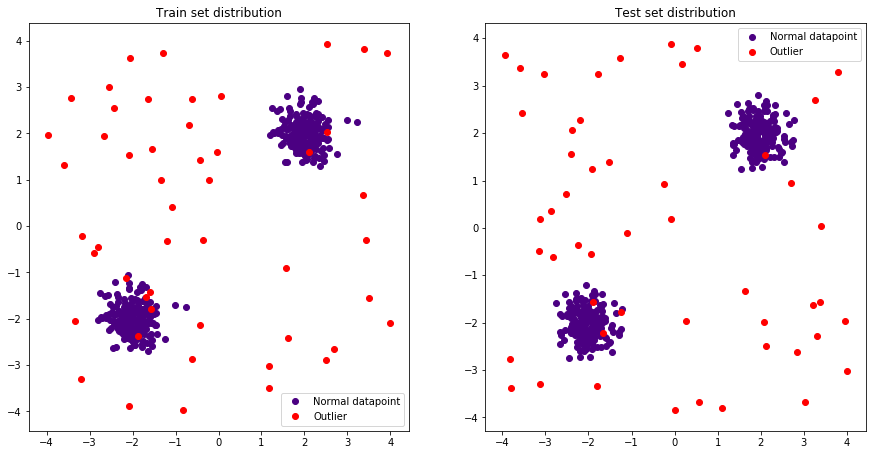

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))

# Plot train set
ax1.set_title('Train set distribution')
ax1.scatter(X_train_normal[:, 0], X_train_normal[:, 1], color='indigo')
ax1.scatter(X_train_outliers[:, 0], X_train_outliers[:, 1], color='red')

# Legend for train set
legend_elements = [Line2D([], [], marker='o', label='Normal datapoint', color='indigo', linestyle='None'),
                   Line2D([], [], marker='o', label='Outlier', color='red', linestyle='None')]
ax1.legend(handles=legend_elements)

# Plot test set
ax2.set_title('Test set distribution')
ax2.scatter(X_test_normal[:, 0], X_test_normal[:, 1], color='indigo')
ax2.scatter(X_test_outliers[:, 0], X_test_outliers[:, 1], color='red')

# Legend for test set
legend_elements = [Line2D([], [], marker='o', label='Normal datapoint', color='indigo', linestyle='None'),
                   Line2D([], [], marker='o', label='Outlier', color='red', linestyle='None')]
ax2.legend(handles=legend_elements)
plt.show()

---

# Isolation Forest

We will create an **Isolation forest**, which in a few words is an *unsupervised learning algorithm* that works on the principle of isolating *anomalies*.

Instead of doing as most techniques -constructing a profile of what is "normal"-, this technique instead focuses on isolating anomalous data points (observations or events that deviates from other events) within the dataset.

## Terms

**Contamination:** Assumption about the fraction of anomalies in the dataset. 
In a real-life case, this number would normally be set by the intuition of the domain experts -generally the domain experts will have a rough idea about the fraction of the anomalies in the dataset-. For most cases, a value of 0.1 works.

## Definition & training

At this point, we will simply define our Isolation Forest and fit it on the training set we created on steps above

In [12]:
clf = IsolationForest(behaviour='new', random_state=42, contamination=0.1)
clf.fit(X_train)

IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=42, verbose=0, warm_start=False)

## Run predictions

In [13]:
y_train = clf.predict(X_train)
y_test = clf.predict(X_test) 

**Correlate predicted anomalies with original sets**

We will now use the function we defined above to get all the points marked as outlines, so we can later take metrics regarding accuracy

In [14]:
train_anom = correlate_indexes(y_train, X_train)
test_anom = correlate_indexes(y_test, X_test)

## Plots

Now we have our predictions ready, let's plot and see how good did our model perform on both training and testing data

**Train set**

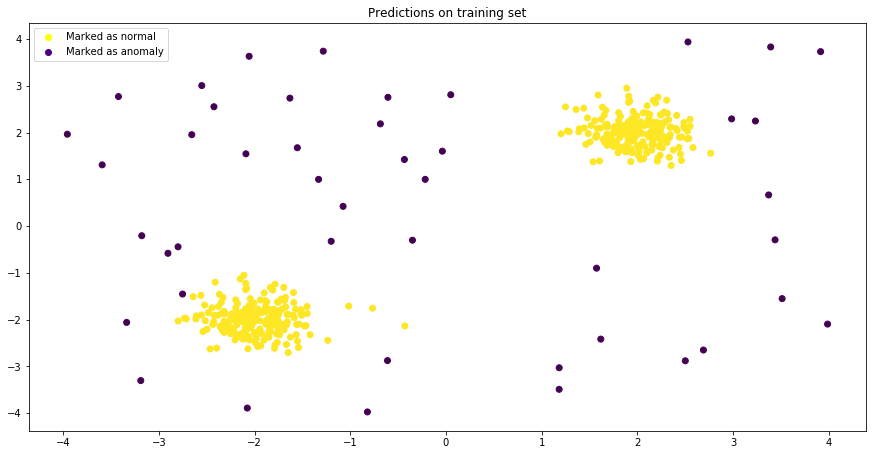

In [15]:
plt.figure(figsize=(15, 7.5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.title('Predictions on training set')

# This is to set the legend appropriately
legend_elements = [Line2D([], [], marker='o', color='yellow', label='Marked as normal', linestyle='None'),
                   Line2D([], [], marker='o', color='indigo', label='Marked as anomaly', linestyle='None')]
plt.legend(handles=legend_elements)
plt.show()

**Test set**

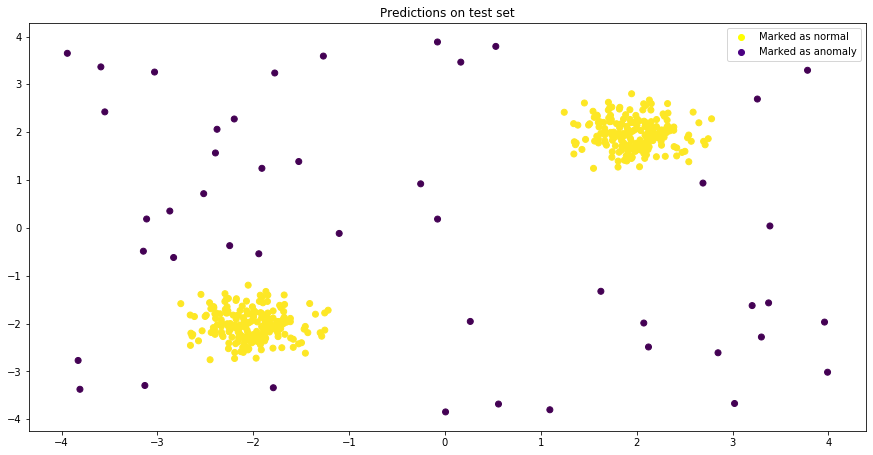

In [16]:
plt.figure(figsize=(15, 7.5))
plt.title('Predictions on test set')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

legend_elements = [Line2D([], [], marker='o', color='yellow', label='Marked as normal', linestyle='None'),
                   Line2D([], [], marker='o', color='indigo', label='Marked as anomaly', linestyle='None')]
plt.legend(handles=legend_elements)
plt.show()

## Comparative charts

### Anomalies

**Train set**

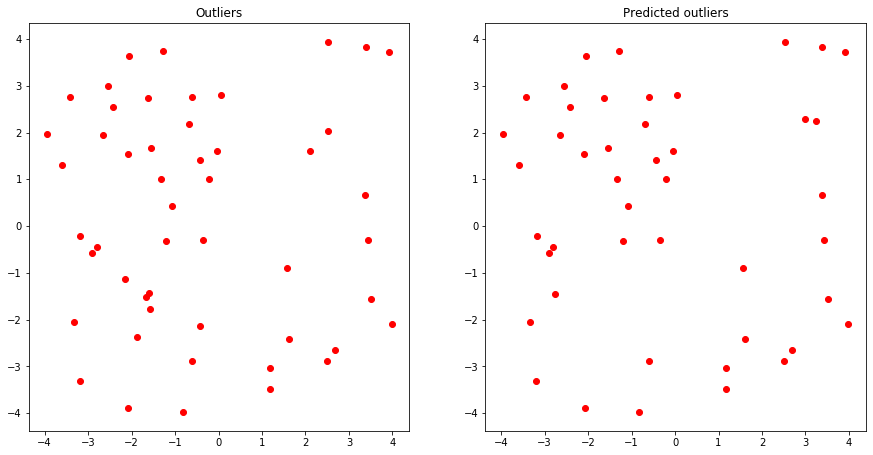

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))

# Plot train set
ax1.set_title('Outliers')
ax1.scatter(X_train_outliers[:, 0], X_train_outliers[:, 1], color='red')

# Plot test set
ax2.set_title('Predicted outliers')
ax2.scatter(train_anom[:, 0], train_anom[:, 1], color='red')
plt.show()

### Stats

In [18]:
false_outliers = np.array([val for val in train_anom if val not in X_train_outliers and val in X_train_normal])
undetected_outliers = np.array([val for val in X_train_outliers if val not in train_anom])

correct_outliers = np.array([val for val in train_anom if val in X_train_outliers])

print('Anomalies in original dataset: {}'.format(X_train_outliers.shape[0]))
print('Predicted anomalies: {}'.format(train_anom.shape[0]))

print('Correct outlier detections: {}'.format(len(correct_outliers)))
print('False outlier detections: {}'.format(len(false_outliers)))
print('Undetected outliers: {}'.format(len(undetected_outliers)))

Anomalies in original dataset: 50
Predicted anomalies: 45
Correct outlier detections: 42
False outlier detections: 3
Undetected outliers: 8


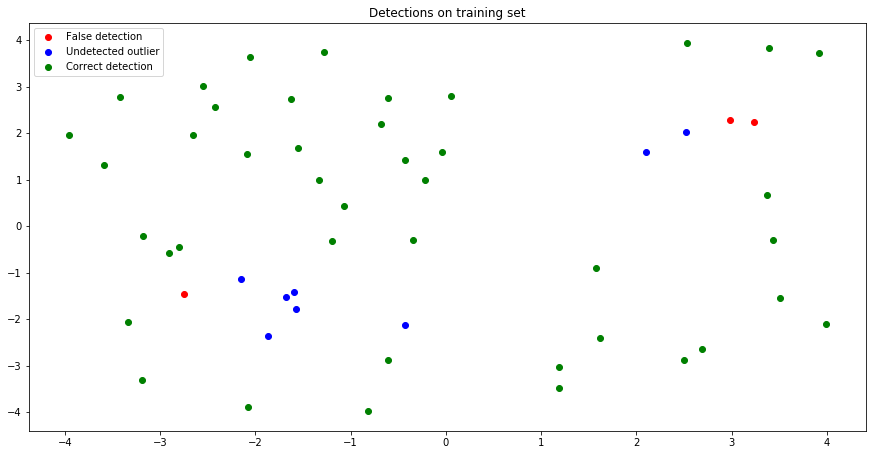

In [19]:
plt.figure(figsize=(15, 7.5))
plt.title('Detections on training set')
plt.scatter(false_outliers[:, 0], false_outliers[:, 1], color='r')
plt.scatter(correct_outliers[:, 0], correct_outliers[:, 1], color='g')
plt.scatter(undetected_outliers[:, 0], undetected_outliers[:, 1], color='b')

legend_elements = [Line2D([], [], marker='o', color='r', label='False detection', linestyle='None'),
                   Line2D([], [], marker='o', color='b', label='Undetected outlier', linestyle='None'),
                   Line2D([], [], marker='o', color='g', label='Correct detection', linestyle='None')]
plt.legend(handles=legend_elements)
plt.show()

### Metrics

In [20]:
metrics_gen(X_train_outliers, train_anom, correct_outliers, false_outliers, undetected_outliers)

Accuracy on test set: 84.00%
False detection ratio: 6.52%
Undetection ratio: 16.00%


**Test set**

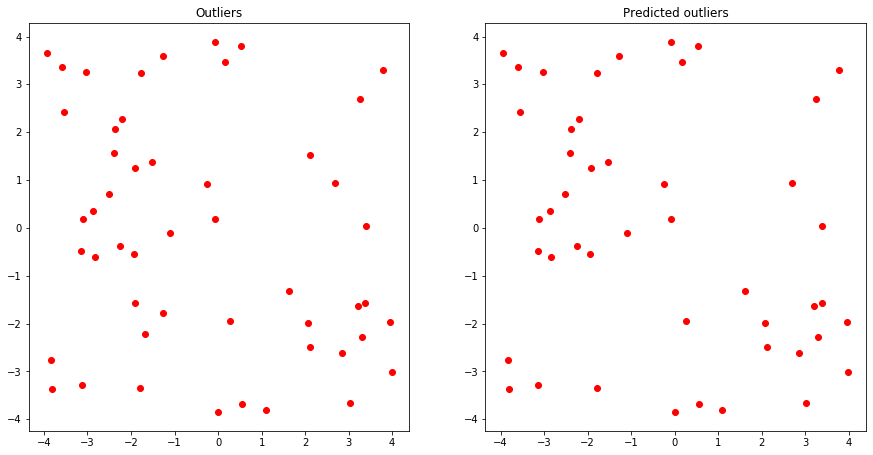

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))

# Plot train set
ax1.set_title('Outliers')
ax1.scatter(X_test_outliers[:, 0], X_test_outliers[:, 1], color='red')

# Plot test set
ax2.set_title('Predicted outliers')
ax2.scatter(test_anom[:, 0], test_anom[:, 1], color='red')
plt.show()

### Stats

In [22]:
false_outliers = np.array([val for val in test_anom if val not in X_test_outliers and val in X_test_normal])
undetected_outliers = np.array([val for val in X_test_outliers if val not in test_anom])

correct_outliers = np.array([val for val in test_anom if val in X_test_outliers])

print('Anomalies in original dataset: {}'.format(X_test_outliers.shape[0]))
print('Predicted anomalies: {}'.format(test_anom.shape[0]))
print('Correct outlier detections: {}'.format(len(correct_outliers)))
print('False outlier detections: {}'.format(len(false_outliers)))
print('Undetected outliers: {}'.format(len(undetected_outliers)))

Anomalies in original dataset: 50
Predicted anomalies: 46
Correct outlier detections: 46
False outlier detections: 0
Undetected outliers: 4


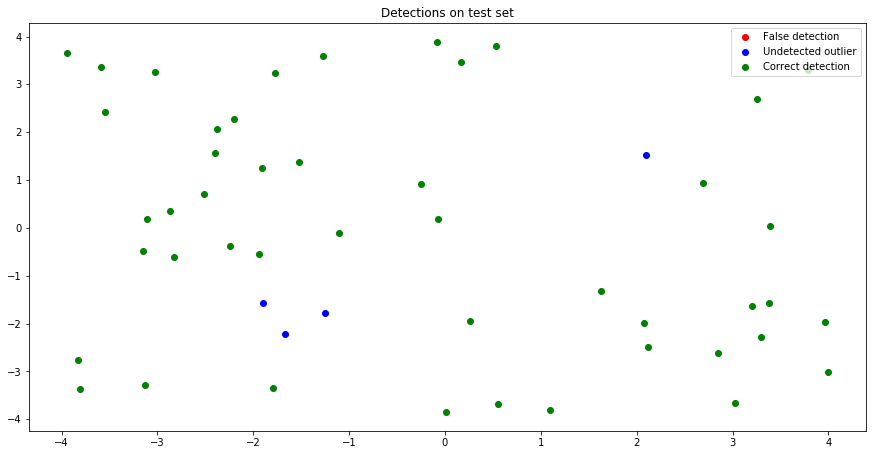

In [23]:
plt.figure(figsize=(15, 7.5))
plt.title('Detections on test set')

if len(false_outliers):
    plt.scatter(false_outliers[:, 0], false_outliers[:, 1], color='r')
plt.scatter(correct_outliers[:, 0], correct_outliers[:, 1], color='g')
plt.scatter(undetected_outliers[:, 0], undetected_outliers[:, 1], color='b')

legend_elements = [Line2D([], [], marker='o', color='r', label='False detection', linestyle='None'),
                   Line2D([], [], marker='o', color='b', label='Undetected outlier', linestyle='None'),
                   Line2D([], [], marker='o', color='g', label='Correct detection', linestyle='None')]
plt.legend(handles=legend_elements)
plt.show()

### Metrics

In [24]:
metrics_gen(X_train_outliers, train_anom, correct_outliers, false_outliers, undetected_outliers)

Accuracy on test set: 92.00%
False detection ratio: 0.00%
Undetection ratio: 8.00%


---

# One Class Support Vector Machine

Unsupervised learning algorithm, suited for anomaly detection. In one-class SVM, the support vector model is trained on data that has only one class, which is the *normal* class. It learns the boundaries of these points and is therefore able to classify any points that lie outside the boundary (outliers).

The main difference from a standard SVM is that it is fit in an unsupervised manner

## Definition & training


The *nu* parameter should be approximately the proportion of outliers you expect to observe, meanwhile the gamma parameter determines the smoothing of the contour lines.

In [25]:
svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)
svm.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

## Predictions

In [26]:
pred = svm.predict(X_train)
pred_test = svm.predict(X_test)

Get outliers from original set by correlating indexes agains the base set

In [27]:
train_anom = correlate_indexes(pred, X_train)
test_anom = correlate_indexes(pred_test, X_test)

## Plots

**Train set**

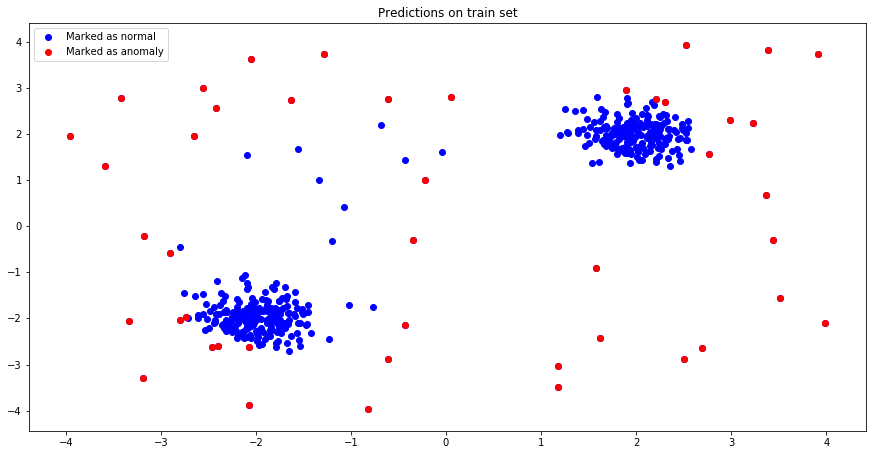

In [28]:
plt.figure(figsize=(15, 7.5))
plt.title('Predictions on train set')
plt.scatter(X_train[:, 0], X_train[:, 1], color='b')
plt.scatter(train_anom[:, 0], train_anom[:, 1], color='r')

legend_elements = [Line2D([], [], marker='o', color='b', label='Marked as normal', linestyle='None'),
                   Line2D([], [], marker='o', color='r', label='Marked as anomaly', linestyle='None')]
plt.legend(handles=legend_elements)
plt.show()

**Test set**

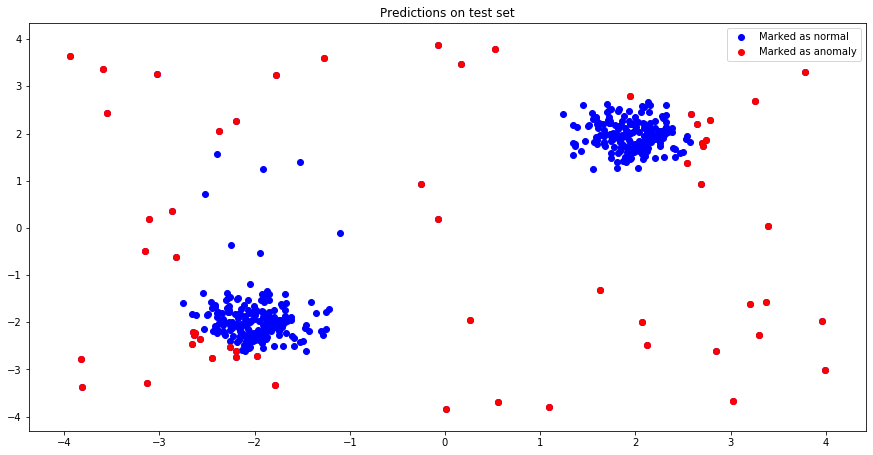

In [29]:
plt.figure(figsize=(15, 7.5))
plt.title('Predictions on test set')
plt.scatter(X_test[:, 0], X_test[:, 1], color='b')
plt.scatter(test_anom[:, 0], test_anom[:, 1], color='r')

legend_elements = [Line2D([], [], marker='o', color='b', label='Marked as normal', linestyle='None'),
                   Line2D([], [], marker='o', color='r', label='Marked as anomaly', linestyle='None')]
plt.legend(handles=legend_elements)
plt.show()

## Comparative Charts

### Anomalies

**Train set**

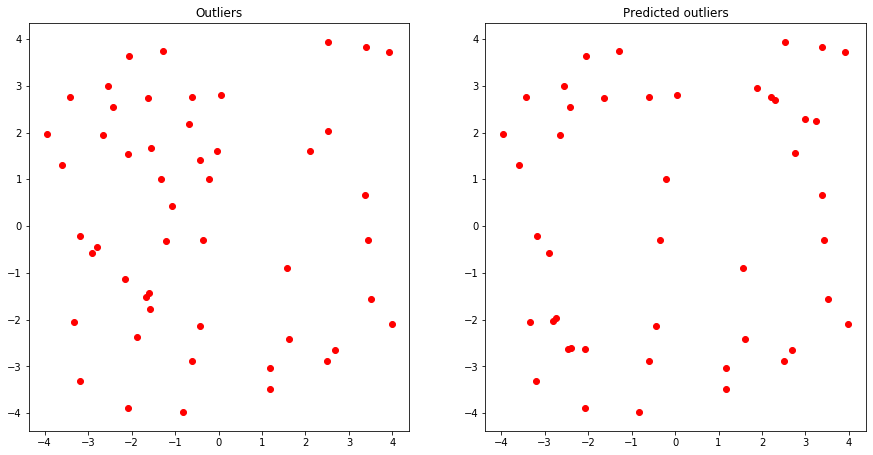

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))

# Plot train set
ax1.set_title('Outliers')
ax1.scatter(X_train_outliers[:, 0], X_train_outliers[:, 1], color='red')

# Plot test set
ax2.set_title('Predicted outliers')
ax2.scatter(train_anom[:, 0], train_anom[:, 1], color='red')
plt.show()

### Stats

In [31]:
false_outliers = np.array([val for val in train_anom if val not in X_train_outliers and val in X_train_normal])
undetected_outliers = np.array([val for val in X_train_outliers if val not in train_anom])

correct_outliers = np.array([val for val in train_anom if val in X_train_outliers])

print('Anomalies in original dataset: {}'.format(X_train_outliers.shape[0]))
print('Predicted anomalies: {}'.format(train_anom.shape[0]))
print('Correct outlier detections: {}'.format(len(correct_outliers)))
print('False outlier detections: {}'.format(len(false_outliers)))
print('Undetected outliers: {}'.format(len(undetected_outliers)))

Anomalies in original dataset: 50
Predicted anomalies: 45
Correct outlier detections: 34
False outlier detections: 11
Undetected outliers: 16


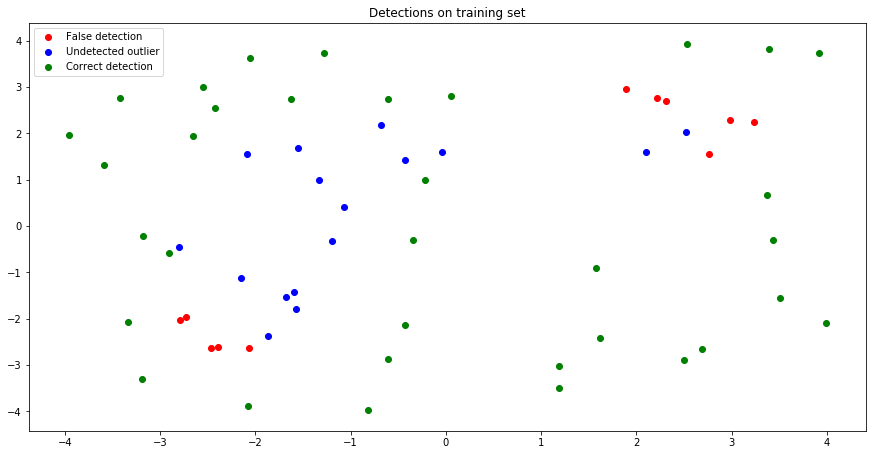

In [32]:
plt.figure(figsize=(15, 7.5))
plt.title('Detections on training set')
plt.scatter(false_outliers[:, 0], false_outliers[:, 1], color='r')
plt.scatter(correct_outliers[:, 0], correct_outliers[:, 1], color='g')
plt.scatter(undetected_outliers[:, 0], undetected_outliers[:, 1], color='b')

legend_elements = [Line2D([], [], marker='o', color='r', label='False detection', linestyle='None'),
                   Line2D([], [], marker='o', color='b', label='Undetected outlier', linestyle='None'),
                   Line2D([], [], marker='o', color='g', label='Correct detection', linestyle='None')]
plt.legend(handles=legend_elements)
plt.show()

### Metrics

In [33]:
metrics_gen(X_train_outliers, train_anom, correct_outliers, false_outliers, undetected_outliers)

Accuracy on test set: 68.00%
False detection ratio: 19.30%
Undetection ratio: 32.00%


**Test set**

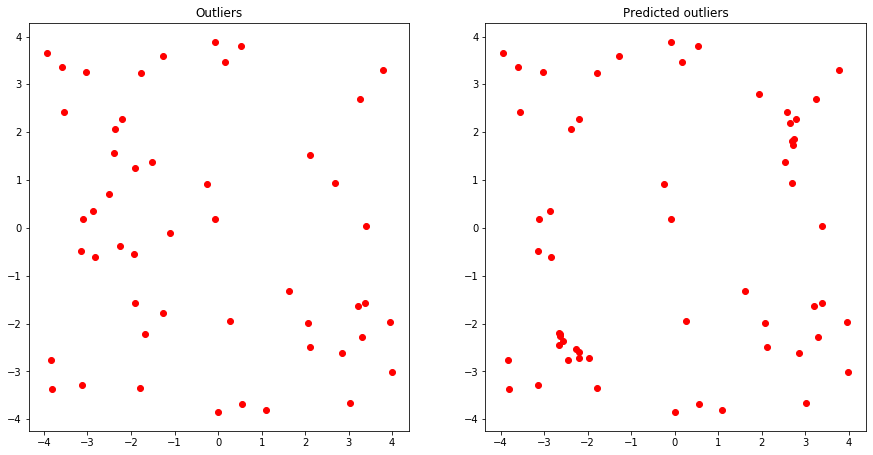

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))

# Plot train set
ax1.set_title('Outliers')
ax1.scatter(X_test_outliers[:, 0], X_test_outliers[:, 1], color='red')

# Plot test set
ax2.set_title('Predicted outliers')
ax2.scatter(test_anom[:, 0], test_anom[:, 1], color='red')
plt.show()

### Stats

In [35]:
false_outliers = np.array([val for val in test_anom if val not in X_test_outliers and val in X_test_normal])
undetected_outliers = np.array([val for val in X_test_outliers if val not in test_anom])

correct_outliers = np.array([val for val in test_anom if val in X_test_outliers])

print('Anomalies in original dataset: {}'.format(X_test_outliers.shape[0]))
print('Predicted anomalies: {}'.format(test_anom.shape[0]))
print('Correct outlier detections: {}'.format(len(correct_outliers)))
print('False outlier detections: {}'.format(len(false_outliers)))
print('Undetected outliers: {}'.format(len(undetected_outliers)))

Anomalies in original dataset: 50
Predicted anomalies: 57
Correct outlier detections: 39
False outlier detections: 18
Undetected outliers: 11


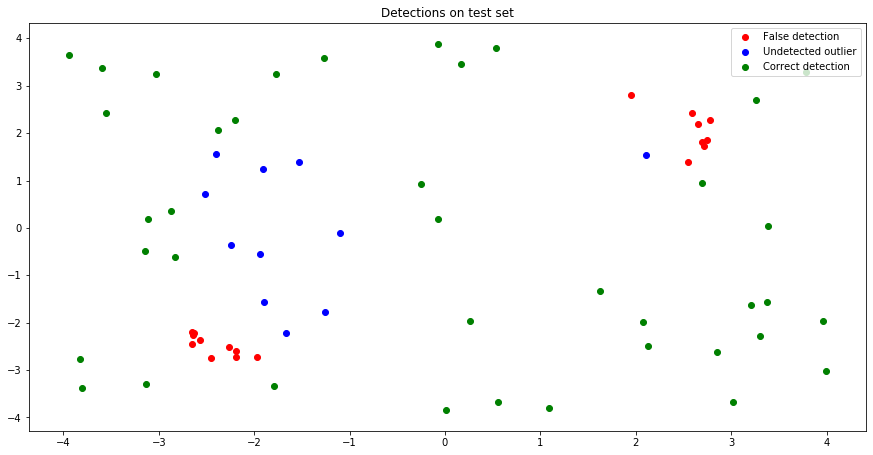

In [36]:
plt.figure(figsize=(15, 7.5))
plt.title('Detections on test set')
plt.scatter(false_outliers[:, 0], false_outliers[:, 1], color='r')
plt.scatter(correct_outliers[:, 0], correct_outliers[:, 1], color='g')
plt.scatter(undetected_outliers[:, 0], undetected_outliers[:, 1], color='b')

legend_elements = [Line2D([], [], marker='o', color='r', label='False detection', linestyle='None'),
                   Line2D([], [], marker='o', color='b', label='Undetected outlier', linestyle='None'),
                   Line2D([], [], marker='o', color='g', label='Correct detection', linestyle='None')]
plt.legend(handles=legend_elements)
plt.show()

### Metrics

In [37]:
metrics_gen(X_train_outliers, train_anom, correct_outliers, false_outliers, undetected_outliers)

Accuracy on test set: 78.00%
False detection ratio: 31.58%
Undetection ratio: 22.00%
